# **0: [Optional]Data Acquisition**

In [1]:
# mount Google Drive to Google Colab notebook
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# set the Kaggle configuration path to kaggle.json
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/deep_learning"

In [3]:
# change the working directory
%cd /content/gdrive/MyDrive/deep_learning/data

/content/gdrive/MyDrive/deep_learning/data


In [4]:
!kaggle datasets download -d cookiefinder/tomato-disease-multiple-sources

tomato-disease-multiple-sources.zip: Skipping, found more recently modified local copy (use --force to force download)


### Copy Raw Data Files From Google Drive To Local Colab Session to Avoid Disrupt Connections

In [5]:
# create 'data' folder in local VM
!mkdir /content/data

In [6]:
# copy .zip and unzip in local VM to avoid exceed Google Drive daily limits
!cp -r /content/gdrive/MyDrive/deep_learning/data/tomato-disease-multiple-sources.zip /content/data

In [7]:
# change the working directory to local VM
%cd /content/data

/content/data


In [8]:
# unzip using python library
import zipfile

with zipfile.ZipFile('tomato-disease-multiple-sources.zip','r') as zip_ref:
  zip_ref.extractall('./')

In [9]:
# audit: make sure we have 25,851 images in train and 6,684 images in valid
train_len, test_len = 0, 0
TRAIN_DATA_PATH = '/content/data/train'
VALID_DATA_PATH = '/content/data/valid'

for f in os.listdir(TRAIN_DATA_PATH):
  train_len += len(os.listdir(os.path.join(TRAIN_DATA_PATH, f)))
  test_len += len(os.listdir(os.path.join(VALID_DATA_PATH, f)))

print("{} images in training set".format(train_len))
print("{} images in test set.".format(test_len))
assert train_len == 25851, "Missing images in training set. It should include 25,851 images"
assert test_len == 6684, "Missing images in valid set. It should include 6,684 images"

25851 images in training set
6684 images in test set.


# **1: Do the preparation for transfer learning**

In [10]:
!pip install keras-tuner -q

# data manipulation
import numpy as np
import pandas as pd

# image processing
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# data preprocessing and modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from pathlib import Path
import imghdr

# hyperparameter tuning
import keras_tuner

# sklearn utility functions
from sklearn.metrics import confusion_matrix, classification_report

# others
import os, gc, time, datetime, tqdm, glob 
from skimage import io 

# set up random seed
import random
seed = 24

# customize printing
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('max_colwidth', 200)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 KB 9.1 MB/s eta 0:00:00


In [11]:
# environmental variables
TRAIN_DATA_PATH = '/content/data/train'
VALID_DATA_PATH = '/content/data/valid'

CLASSES = sorted(os.listdir(TRAIN_DATA_PATH))
NUM_CLASSES = len(CLASSES)
TIMESTAMP = str(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
print(TIMESTAMP)

20230406-060530


Define utility functions


*   training history plot
*   confusion matrix


In [12]:
def plot_training(hist):
  '''
  This function plots training history. (ie training loss vs validation loss)
  '''
  tr_acc = hist.history['accuracy']
  tr_loss = hist.history['loss']
  val_acc = hist.history['val_accuracy']
  val_loss = hist.history['val_loss']
  index_loss = np.argmin(val_loss)
  val_lowest = val_loss[index_loss]
  index_acc = np.argmax(val_acc)
  acc_highest = val_acc[index_acc]

  plt.figure(figsize= (20, 8))
  plt.style.use('fivethirtyeight')
  Epochs = [i+1 for i in range(len(tr_acc))]
  loss_label = f'best epoch= {str(index_loss + 1)}'
  acc_label = f'best epoch= {str(index_acc + 1)}'

  plt.subplot(1, 2, 1)
  plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
  plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
  plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
  plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
  plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.tight_layout
  plt.show()

In [13]:
def make_confusion_matrix(cf, group_names=None,categories='auto', count=True,percent=False,cbar=True, 
                          xyticks=True,xyplotlabels=True,sum_stats=True,figsize=None,
                          cmap='Blues',title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
     

# **2.Remove Corrupted Images**
TensorFlow has some strictness when dealing with image formats. Some times your data set may even run well with, for instance Torch but will generate a format error with Tf. Nonetheless, it is best practice to always carryout preprocessing on the images to ensure a robust, safe and standard model.

In [14]:
def image_quality_check(image_dir):
  '''
  This functions checks whether file formats accepted by Tensorflow ( JPEG, PNG, GIF, BMP), or may be corrupted.
  '''
  from pathlib import Path
  import imghdr

  image_extensions = ['.jpg', '.png', '.jpeg', '.PNG', '.JPG', '.JPEG']
  img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
  bad_images = []

  for filepath in Path(image_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            bad_images.append(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            bad_images.append(filepath)
  return bad_images

In [15]:
def image_quality_check2(image_dir):
  '''
  This function captures corrupted image files (jpg and png) that may missed by first QA function.
  '''
  import os, glob

  # validate directory
  assert os.path.exists(image_dir), "Error: directory does not exist"

  bad_images = []
  classes = sorted([c for c in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, c))])

  def is_valid_jpg(jpg_file):
    with open(jpg_file, 'rb') as f:
      f.seek(-2,2)
      buf = f.read()
      return buf == b'\xff\xd9'

  def is_valid_png(png_file):
    with open(png_file, 'rb') as f:
      f.seek(-2,2)
      but = f.read()
      return but == b'\x60\x82'

  for f_class in classes:
    class_path = os.path.join(image_dir, f_class)
    file_list = os.listdir(class_path)
    desc = f'{f_class:23s}'
    for file in tqdm.tqdm(file_list, ncols=110, desc=desc, unit='file', colour='blue'):
      fpath = os.path.join(class_path, file)
      index = file.rfind('.')
      if file[index:] in ['.jpg', '.jpeg','.JPG', '.JPEG']:
        if not is_valid_jpg(fpath):
          print(fpath)
          bad_images.append(fpath)
      
      if file[index:] in ['.png', '.PNG']:
        if not is_valid_png(fpath):
          print(fpath)
          bad_images.append(fpath)
          
        try:
          image = tf.io.read_file(fpath)
          image = tf.image.decode_png(image, channels=3)
        except:
          bad_images.append(fpath)
          print('defective image file: ', fpath)

  return bad_images

In [16]:
# check image quality
%time
print("-"*20, "check training set image quality.","-"*20)
bad_images_train = image_quality_check(TRAIN_DATA_PATH)
print("-"*20, "check test and validation set image quality.","-"*20)
bad_images_val_test = image_quality_check(VALID_DATA_PATH)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.68 µs
-------------------- check training set image quality. --------------------
/content/data/train/Septoria_leaf_spot/SS_ (51).jpg is not an image
/content/data/train/Leaf_Mold/BM_(7).jpg is not an image
/content/data/train/Leaf_Mold/BM_(975).jpg is not an image
/content/data/train/Leaf_Mold/BM_(6).jpg is not an image
/content/data/train/Leaf_Mold/607-155-1.jpg is not an image
/content/data/train/Leaf_Mold/BM_(98).jpg is not an image
/content/data/train/Leaf_Mold/BM_(976).jpg is not an image
/content/data/train/healthy/tomato-leaf-isolated-on-white-260nw-580281301.jpg is not an image
/content/data/train/healthy/branch-tomato-leaves-iaolsted-on-260nw-1025727106.jpg is not an image
/content/data/train/healthy/edible-tomato-leaves.jpg is a webp, not accepted by TensorFlow
/content/data/train/Early_blight/220px-Alternaria_solani_-_leaf_lesions.jpg is not an image
/content/data/train/Early_blight/early-blight-tomato-causal-agents-

In [17]:
# check image quality 2
%time
print("-"*20, "check training set image quality.","-"*20)
bad_images_train2 = image_quality_check2(TRAIN_DATA_PATH)
print("-"*20, "check test and validation set image quality.","-"*20)
bad_images_val_test2 = image_quality_check2(VALID_DATA_PATH)

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 5.48 µs
-------------------- check training set image quality. --------------------


Bacterial_spot         : 100%|███████████████████████████████████████| 2826/2826 [00:00<00:00, 61835.07file/s]


/content/data/train/Bacterial_spot/bacterialspotontomatoXant.JPG


Early_blight           : 100%|███████████████████████████████████████| 2455/2455 [00:00<00:00, 62127.15file/s]


/content/data/train/Early_blight/earlyblighthttp___wwwlsuagcenter.jpg


healthy                :  76%|██████████████████████████████▎         | 2314/3051 [00:01<00:00, 1319.64file/s]

/content/data/train/healthy/edible-tomato-leaves.jpg


healthy                :  98%|███████████████████████████████████████▎| 2994/3051 [00:02<00:00, 1249.13file/s]

/content/data/train/healthy/A-Healthy-leaves-of-tomato-plants-and-B-Leaves-of-tomato-plants-inoculated-with.png


powdery_mildew         : 100%|███████████████████████████████████████| 1004/1004 [00:00<00:00, 63636.49file/s]


-------------------- check test and validation set image quality. --------------------


Leaf_Mold              : 100%|█████████████████████████████████████████| 739/739 [00:00<00:00, 53979.15file/s]


/content/data/valid/Leaf_Mold/BM_(9).jpg


healthy                :  59%|█████████████████████████▎                 | 474/806 [00:00<00:00, 840.40file/s]

/content/data/valid/healthy/HL_(336).png
defective image file:  /content/data/valid/healthy/HL_(336).png
/content/data/valid/healthy/2013-08-20-05.jpg


powdery_mildew         : 100%|█████████████████████████████████████████| 252/252 [00:00<00:00, 32985.82file/s]


In [18]:
move_bad_images = True
bad_images = set(bad_images_train + bad_images_val_test + bad_images_train2 + bad_images_val_test2)
bad_images

if move_bad_images:
  for link in bad_images:
    if os.path.exists(link):
      os.remove(str(link))

print('Move {} images with bad quality.'.format(len(bad_images)))

{'/content/data/train/Bacterial_spot/bacterialspotontomatoXant.JPG',
 PosixPath('/content/data/train/Early_blight/220px-Alternaria_solani_-_leaf_lesions.jpg'),
 PosixPath('/content/data/train/Early_blight/EB_(976).jpg'),
 PosixPath('/content/data/train/Early_blight/early-blight-tomato-causal-agents-260nw-1746486380.jpg'),
 '/content/data/train/Early_blight/earlyblighthttp___wwwlsuagcenter.jpg',
 PosixPath('/content/data/train/Leaf_Mold/607-155-1.jpg'),
 PosixPath('/content/data/train/Leaf_Mold/BM_(6).jpg'),
 PosixPath('/content/data/train/Leaf_Mold/BM_(7).jpg'),
 PosixPath('/content/data/train/Leaf_Mold/BM_(975).jpg'),
 PosixPath('/content/data/train/Leaf_Mold/BM_(976).jpg'),
 PosixPath('/content/data/train/Leaf_Mold/BM_(98).jpg'),
 PosixPath('/content/data/train/Septoria_leaf_spot/SS_ (51).jpg'),
 '/content/data/train/healthy/A-Healthy-leaves-of-tomato-plants-and-B-Leaves-of-tomato-plants-inoculated-with.png',
 PosixPath('/content/data/train/healthy/branch-tomato-leaves-iaolsted-on-26

Move 25 images with bad quality.


In [19]:
# check number of images remained
train_len, test_len = 0, 0
for f in os.listdir(TRAIN_DATA_PATH):
  train_len += len(os.listdir(os.path.join(TRAIN_DATA_PATH, f)))
  test_len += len(os.listdir(os.path.join(VALID_DATA_PATH, f)))
print(train_len);print(test_len)

25835
6677


In [20]:
del image_quality_check, image_quality_check2, bad_images_train, bad_images_val_test, bad_images_train2, bad_images_val_test2
gc.collect()

0

# **3.Load the data and do train test valid spilt**

In [21]:
IMG_HEIGHT, IMG_WIDTH = 224, 224 
BATCH_SIZE = 32
LABEL_MODE = 'categorical'  
COLOR_MODE = 'rgb'
VALID_TEST_RATIO = 0.5

In [22]:
# training set - expect 25,851 (25,835) images
train_ds = keras.utils.image_dataset_from_directory(
        directory=TRAIN_DATA_PATH,
        batch_size = BATCH_SIZE, 
        image_size = (IMG_HEIGHT, IMG_WIDTH), 
        label_mode=LABEL_MODE,
        color_mode=COLOR_MODE,
        shuffle=True,
        seed = seed
        )

Found 25835 files belonging to 11 classes.


In [23]:
# validation and test sets - expect 6684 (6,677) images
val_test_ds = keras.utils.image_dataset_from_directory(
        directory=VALID_DATA_PATH,
        batch_size = BATCH_SIZE, 
        image_size = (IMG_HEIGHT, IMG_WIDTH), 
        label_mode=LABEL_MODE,
        color_mode=COLOR_MODE,
        shuffle=True,
        seed = seed,
        validation_split = VALID_TEST_RATIO, 
        subset = 'both',
        )

valid_ds = val_test_ds[0]
test_ds = val_test_ds[1]

Found 6677 files belonging to 11 classes.
Using 3339 files for training.
Using 3338 files for validation.


In [24]:
# audit - make sure validation and test sets are approximately follow same distribution
assert((train_ds.class_names == valid_ds.class_names) and (train_ds.class_names == test_ds.class_names)), 'Labels in training, validation, and test does not match'

# **4.Data Argumentation**

In [25]:
data_augmentation = keras.Sequential(
    [
      layers.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
      layers.RandomRotation(0.1),
      layers.RandomZoom(0.1),
    ], name = 'data_augmentation'
)
     

# **5.Data preprocessing**

In [26]:
preprocessing = keras.Sequential(
    [
      keras.layers.Lambda(lambda x: preprocess_input(x))      
    ], name='preprocessing'
)

# **6.Transfer learning with MobileNet**

#### Step 1 - Define Model Architecture and Hyperparameter Search Space

In [27]:
#Load the MobileNet model
model_MobileNet = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

17225924/17225924 [==============================] - 0s 0us/step


In [28]:
#Freeze the parameters
for layer in model_MobileNet.layers:
    layer.trainable = False

In [29]:
keras.backend.clear_session()

In [30]:
def model_initialize(hp_dropout_rate_1, hp_dropout_rate_2, hp_learning_rate):
  model = tf.keras.Sequential()
  model.add(data_augmentation)
  model.add(preprocessing)
  model.add(model_MobileNet)

  model.add(GlobalAveragePooling2D())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(rate=hp_dropout_rate_1))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(rate=hp_dropout_rate_2))
  model.add(Dense(256, activation='relu'))  
  model.add(Dense(units=NUM_CLASSES, activation='softmax'))

  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
    )

  return model         

In [31]:
def model_builder(hp):
  # hyperparameter 1 - dropout rate between layer 1024 and 512
  hp_dropout_rate_1 = hp.Float('dropout_rate_1', min_value=0.0, max_value = 0.5, step = 0.025, sampling = 'linear')

  # hyperparameter 2 - dropout rate between layer 512 and 256
  hp_dropout_rate_2 = hp.Float('dropout_rate_2', min_value=0.0, max_value = 0.5, step = 0.025, sampling = 'linear')

  # hyperparameter 3 - Define the learning rate hyperparameter
  hp_learning_rate = hp.Float('learning_rate', min_value=5e-5, max_value = 5e-04, sampling = 'log')
  
  model = model_initialize( 
      hp_dropout_rate_1 = hp_dropout_rate_1,
      hp_dropout_rate_2 = hp_dropout_rate_2,
      hp_learning_rate = hp_learning_rate
  )

  return model

#### Step 2 - Instantiate the tuner and perform hypertuning
- [Random Search](https://keras.io/api/keras_tuner/tuners/random/)

In [32]:
#!rm /content/hypertune -r
!mkdir /content/hypertune

In [33]:
HP_DIRECTORY = '/content/hypertune'
HP_PROJECT_NAME = 'mobilenet_randomsearch' + TIMESTAMP

In [34]:
# Create the tuner object and search for the best hyperparameters
tuner = keras_tuner.RandomSearch(
    hypermodel=model_builder,
    objective=keras_tuner.Objective('val_loss', direction='min'),
    max_trials=30, # total number of trials (model configurations) to test at most
    directory=HP_DIRECTORY,
    project_name=HP_PROJECT_NAME,
    seed = seed)

In [35]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
dropout_rate_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.025, 'sampling': 'linear'}
dropout_rate_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.025, 'sampling': 'linear'}
learning_rate (Float)
{'default': 5e-05, 'conditions': [], 'min_value': 5e-05, 'max_value': 0.0005, 'step': None, 'sampling': 'log'}


#### Step 3 - Run Tuning using `tuner.search()`
Run the hyperparameter search. The arguments for the `search` method are the same as those used for [`tf.keras.model.fit`](https://keras.io/api/models/model_training_apis/) in addition to the callback above.

In [36]:
# early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    mode='min',
    restore_best_weights=True,
    patience=5, 
    verbose=1
)

In [37]:
tuner.search(
    train_ds,
    validation_data = valid_ds,
    epochs = 50,    
    callbacks = [early_stopping]
)

Trial 30 Complete [00h 12m 02s]
val_loss: 0.1451462209224701

Best val_loss So Far: 0.14051678776741028
Total elapsed time: 03h 29m 34s


Copy hypertune results from local VM to Google Drive

In [38]:
dst='/content/gdrive/MyDrive/deep_learning/hypertune/'
dst

'/content/gdrive/MyDrive/deep_learning/hypertune/'

In [39]:
src=HP_DIRECTORY+'/'+HP_PROJECT_NAME
src

'/content/hypertune/mobilenet_randomsearch20230406-060530'

In [40]:
# copy hypretune log and tensorboard file to gdrive
!cp -R  $src  $dst

In [41]:
tuner.search(train_ds, epochs=50, validation_data=valid_ds)

#### Step 4 - Get optimal hyperparameters and models from the tuner

In [42]:
# check tuner results
tuner.results_summary()

Results summary
Results in /content/hypertune/mobilenet_randomsearch20230406-060530
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 23 summary
Hyperparameters:
dropout_rate_1: 0.45
dropout_rate_2: 0.25
learning_rate: 0.0002878269678929686
Score: 0.14051678776741028

Trial 15 summary
Hyperparameters:
dropout_rate_1: 0.325
dropout_rate_2: 0.45
learning_rate: 0.00010537154554799555
Score: 0.14116203784942627

Trial 29 summary
Hyperparameters:
dropout_rate_1: 0.4
dropout_rate_2: 0.225
learning_rate: 5.364451516482566e-05
Score: 0.1451462209224701

Trial 13 summary
Hyperparameters:
dropout_rate_1: 0.2
dropout_rate_2: 0.225
learning_rate: 0.0001299313657989077
Score: 0.14545761048793793

Trial 06 summary
Hyperparameters:
dropout_rate_1: 0.30000000000000004
dropout_rate_2: 0.0
learning_rate: 0.00012808724469969785
Score: 0.14580579102039337

Trial 10 summary
Hyperparameters:
dropout_rate_1: 0.45
dropout_rate_2: 0.025
learning_rate: 0.00046226306269655756
Score: 0.146

In [43]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0] # num_trials: number of `HyperParameters` objects to return sorted from best to worst

In [44]:
print(f"""
The hyperparameter search is complete. 
The best hyperparameters are: 
""")

for k,v in best_hps.values.items():
  print("{}:{}".format(k, v))


The hyperparameter search is complete. 
The best hyperparameters are: 

dropout_rate_1:0.45
dropout_rate_2:0.25
learning_rate:0.0002878269678929686


In [45]:
# save best hyperparameters to json file and save to gdrive
import json
HP_JSON='/content/hp_'+TIMESTAMP+'.json'
HP_JSON

'/content/hp_20230406-060530.json'

In [46]:
with open(HP_JSON, 'w') as fp:
    json.dump(best_hps.values, fp)

In [47]:
!cp -r  $HP_JSON $dst/$HP_PROJECT_NAME

#### Step 5 - Retrain the model using the optimal hyperparameters obtained during the search to find the optimal number of epochs.

In [48]:
# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

Early Stopping

In [49]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    mode='min',
    restore_best_weights=True,
    patience=5, 
    verbose=1
)

checkpoints

In [50]:
# check point - save best model
model_name = 'mobilenet'
model_type = 'hypertune-best'
parent_folder = '/content/gdrive/MyDrive/deep_learning/model'
model_version = 'hp1'

assert os.path.exists(parent_folder), "Error: directory does not exist"
model_fpath = '/content/gdrive/MyDrive/deep_learning/model/'+ model_name +'_'+ model_type +'_'+TIMESTAMP+'_'+model_version+'.hdf5'
print(model_fpath)

/content/gdrive/MyDrive/deep_learning/model/mobilenet_hypertune-best_20230406-060530_hp1.hdf5


In [51]:
check_point_final = keras.callbacks.ModelCheckpoint(filepath=model_fpath,
                              monitor='val_loss',
                              mode='min',
                              save_best_only=True,
                              save_weights_only=False
                              )

Model Training

In [53]:
history = model.fit(
    train_ds,
    validation_data = valid_ds,
    epochs = 50,  
    callbacks = [early_stopping, check_point_final]
)

Epoch 1/50
808/808 [==============================] - 22s 23ms/step - loss: 0.9286 - accuracy: 0.6765 - val_loss: 0.5026 - val_accuracy: 0.8290
Epoch 2/50
808/808 [==============================] - 18s 22ms/step - loss: 0.5392 - accuracy: 0.8139 - val_loss: 0.3608 - val_accuracy: 0.8790
Epoch 3/50
808/808 [==============================] - 18s 22ms/step - loss: 0.4414 - accuracy: 0.8477 - val_loss: 0.3516 - val_accuracy: 0.8790
Epoch 4/50
808/808 [==============================] - 18s 22ms/step - loss: 0.3812 - accuracy: 0.8700 - val_loss: 0.2873 - val_accuracy: 0.9003
Epoch 5/50
808/808 [==============================] - 17s 21ms/step - loss: 0.3450 - accuracy: 0.8799 - val_loss: 0.2926 - val_accuracy: 0.8970
Epoch 6/50
808/808 [==============================] - 18s 22ms/step - loss: 0.3165 - accuracy: 0.8905 - val_loss: 0.2406 - val_accuracy: 0.9227
Epoch 7/50
808/808 [==============================] - 18s 22ms/step - loss: 0.2810 - accuracy: 0.9033 - val_loss: 0.2360 - val_accuracy:

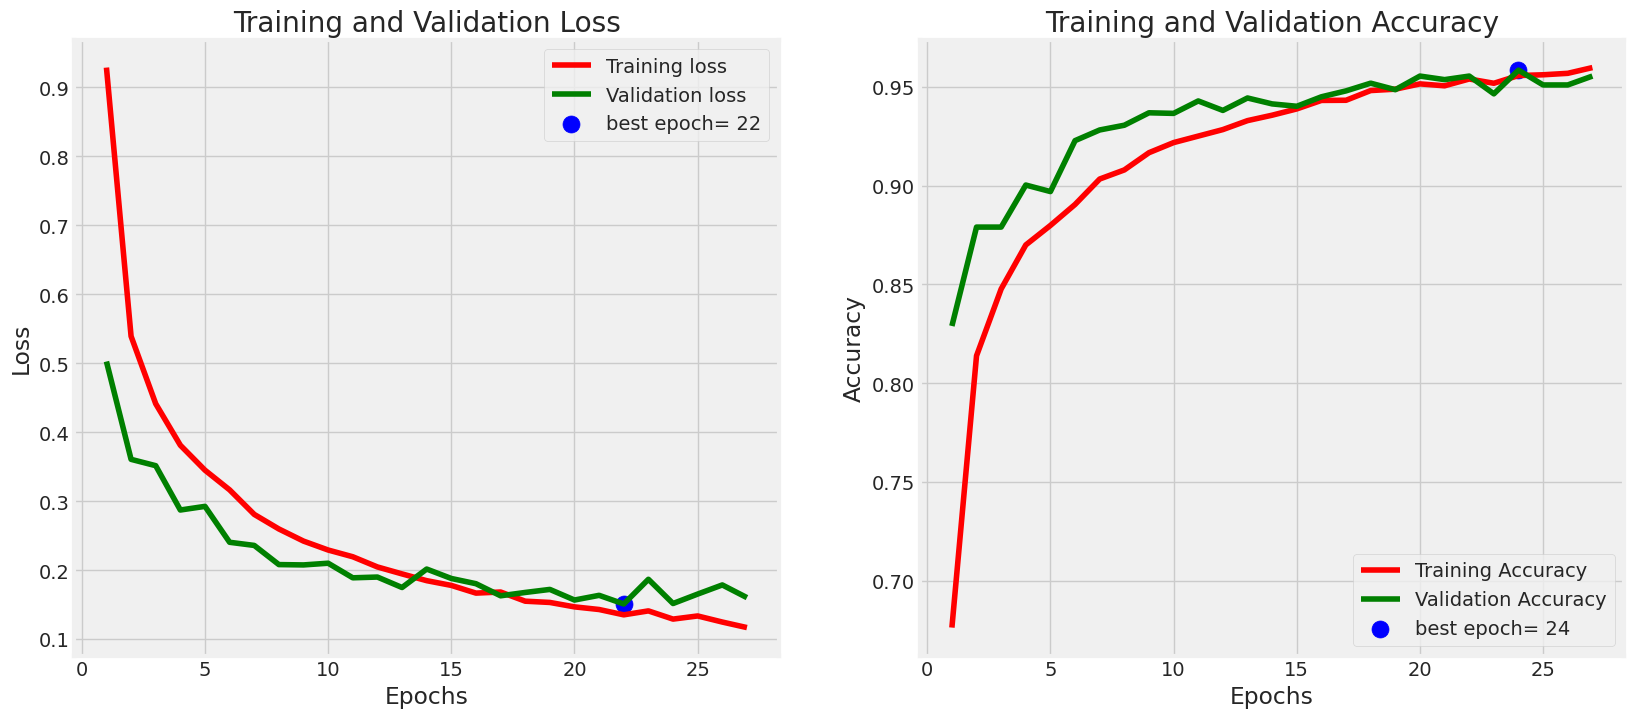

In [54]:
plot_training(history)

#### Step 6 - Evaluate best model performance on test set

In [55]:
test_loss, test_accuracy = model.evaluate(test_ds)

105/105 [==============================] - 2s 20ms/step - loss: 0.1371 - accuracy: 0.9620


In [56]:
train_loss, train_accuracy = model.evaluate(train_ds)
valid_loss, valid_accuracy = model.evaluate(valid_ds)
print("training loss: {} and training accuracy: {}".format(train_loss, train_accuracy))
print("validation loss: {} and validation accuracy: {}".format(valid_loss, valid_accuracy))

105/105 [==============================] - 2s 21ms/step - loss: 0.1511 - accuracy: 0.9554
training loss: 0.060211800038814545 and training accuracy: 0.9797561168670654
validation loss: 0.15113043785095215 and validation accuracy: 0.9553758502006531


In [57]:
y_true = np.array([])
y_pred = np.array([])
for x, y in test_ds:
    y_true = np.concatenate([y_true, np.argmax(y, axis=-1)], axis=0)
    y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis=-1)], axis=0)

1/1 [==============================] - 0s 450ms/step


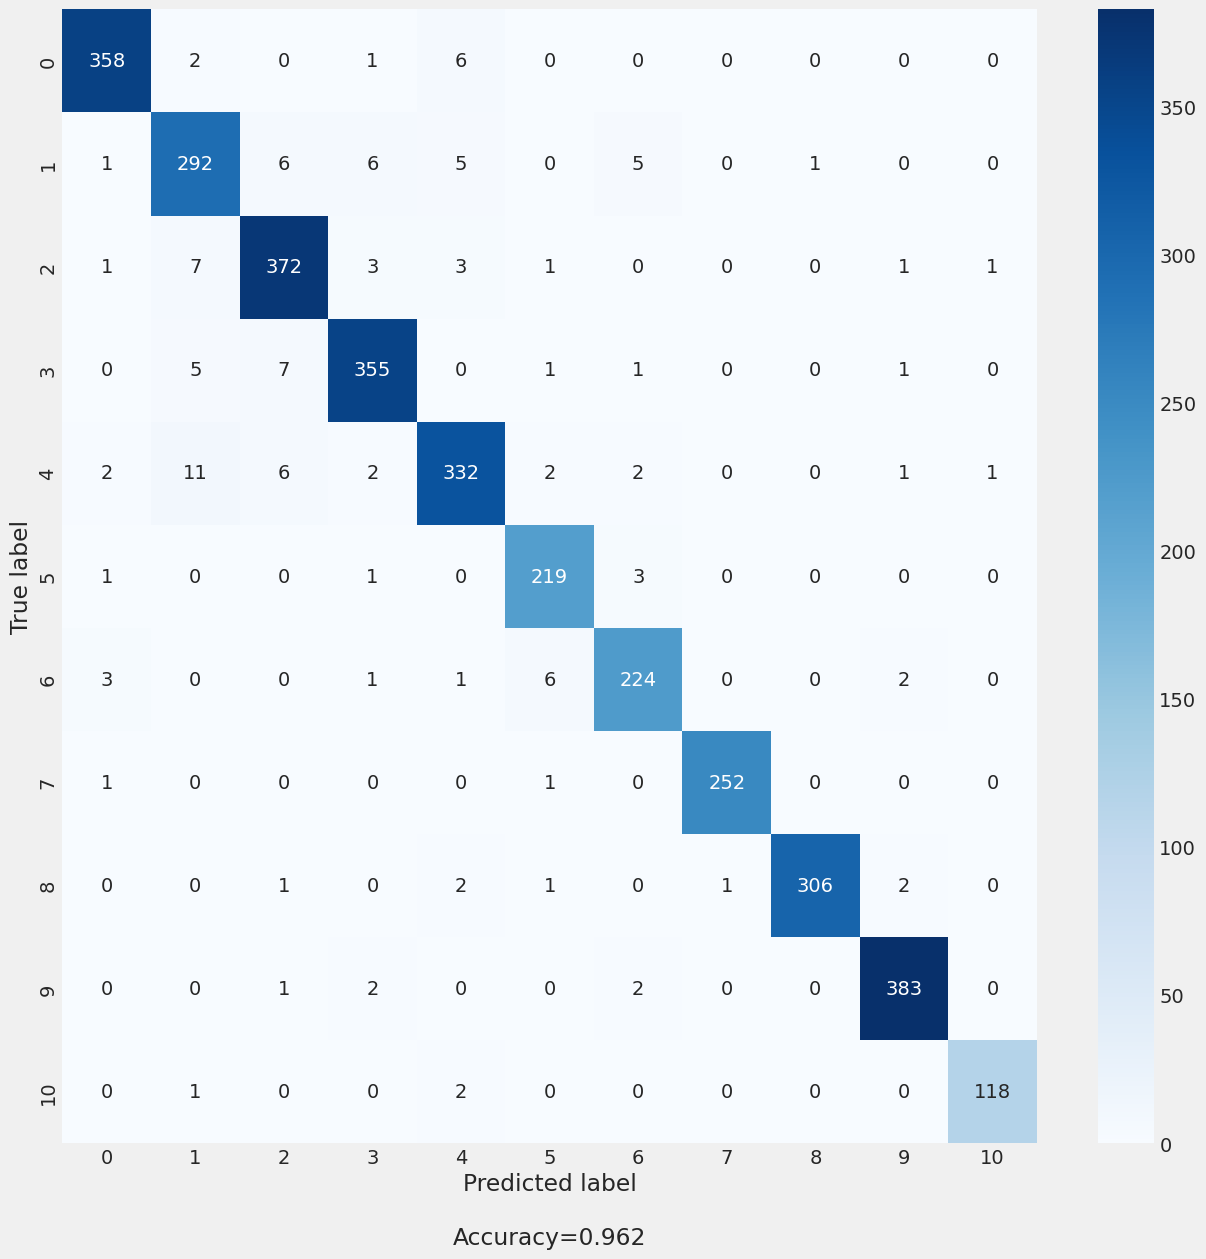

In [58]:
cf = confusion_matrix(y_true, y_pred)
make_confusion_matrix(cf, test_ds.class_names, figsize=(14,14))

## **Follow-up: Load Best Model Back and Generate Additional Performance Metrics**

*  classification report, includes precision, recall, f1-score by classes

*   confusion matrix with target names



**To reuse saved model, we need to complete required data prepration steps:**


*   load images from directory and conduct train/validation/test split to create tf.data.dataset
*   conduct data preprocessing either separately or inside of model pipeline (depends on data preprocessing configuration)

Load Best Model

In [59]:
from keras.models import load_model

In [60]:
model_fpath = '/content/gdrive/MyDrive/deep_learning/model/mobilenet_hypertune/mobilenet_hypertune-best_20230406-060530_hp1.hdf5'

In [61]:
model = load_model(model_fpath)

In [68]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 preprocessing (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1024)              1049600   
                                                      

In [62]:
test_loss, test_accuracy = model.evaluate(test_ds)
print("test loss: {} and test accuracy: {}".format(test_loss, test_accuracy))

105/105 [==============================] - 3s 19ms/step - loss: 0.1371 - accuracy: 0.9620
test loss: 0.13709023594856262 and test accuracy: 0.9619532823562622


Generate Classfication Report

In [63]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [64]:
def plt_confusion_mtrx(y_true, y_pred, target_names):
      # classification report
      print(classification_report(y_true, y_pred, target_names=target_names, digits=3))

      # plot confusion matrix
      conf_mtx = confusion_matrix(y_true, y_pred)
      accuracy = np.trace(conf_mtx) / float(np.sum(conf_mtx))
      disp = ConfusionMatrixDisplay(confusion_matrix=conf_mtx, display_labels=target_names)
      fig, ax = plt.subplots(figsize=(10,10)) 

      # beautify the plot
      disp.plot(cmap='Blues',ax=ax)
      plt.grid(False)
      ax.set_title ('Confusion Matrix for Tomato Leaf Disease - Without Normalization')
      ax.set_xlabel('Predicted labels' + "\n\nAccuracy={:0.3f}".format(accuracy))
      ax.set_ylabel('True label')
      ax.set_xticklabels(target_names, rotation=90)

      plt.show()

In [65]:
target_names = ['Bacterial_spot','Early_blight','Late_blight','Leaf_Mold','Septoria_leaf_spot','Spider_mites Two-spotted_spider_mite',
                'Target_Spot','Tomato_Yellow_Leaf_Curl_Virus','Tomato_mosaic_virus','healthy','powdery_mildew']

In [66]:
y_true = np.array([])
y_pred = np.array([])
for x, y in test_ds:
    y_true = np.concatenate([y_true, np.argmax(y, axis=-1)], axis=0)
    y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis=-1)], axis=0)

1/1 [==============================] - 0s 446ms/step


                                      precision    recall  f1-score   support

                      Bacterial_spot      0.975     0.975     0.975       367
                        Early_blight      0.918     0.924     0.921       316
                         Late_blight      0.947     0.956     0.951       389
                           Leaf_Mold      0.957     0.959     0.958       370
                  Septoria_leaf_spot      0.946     0.925     0.935       359
Spider_mites Two-spotted_spider_mite      0.948     0.978     0.963       224
                         Target_Spot      0.945     0.945     0.945       237
       Tomato_Yellow_Leaf_Curl_Virus      0.996     0.992     0.994       254
                 Tomato_mosaic_virus      0.997     0.978     0.987       313
                             healthy      0.982     0.987     0.985       388
                      powdery_mildew      0.983     0.975     0.979       121

                            accuracy                          

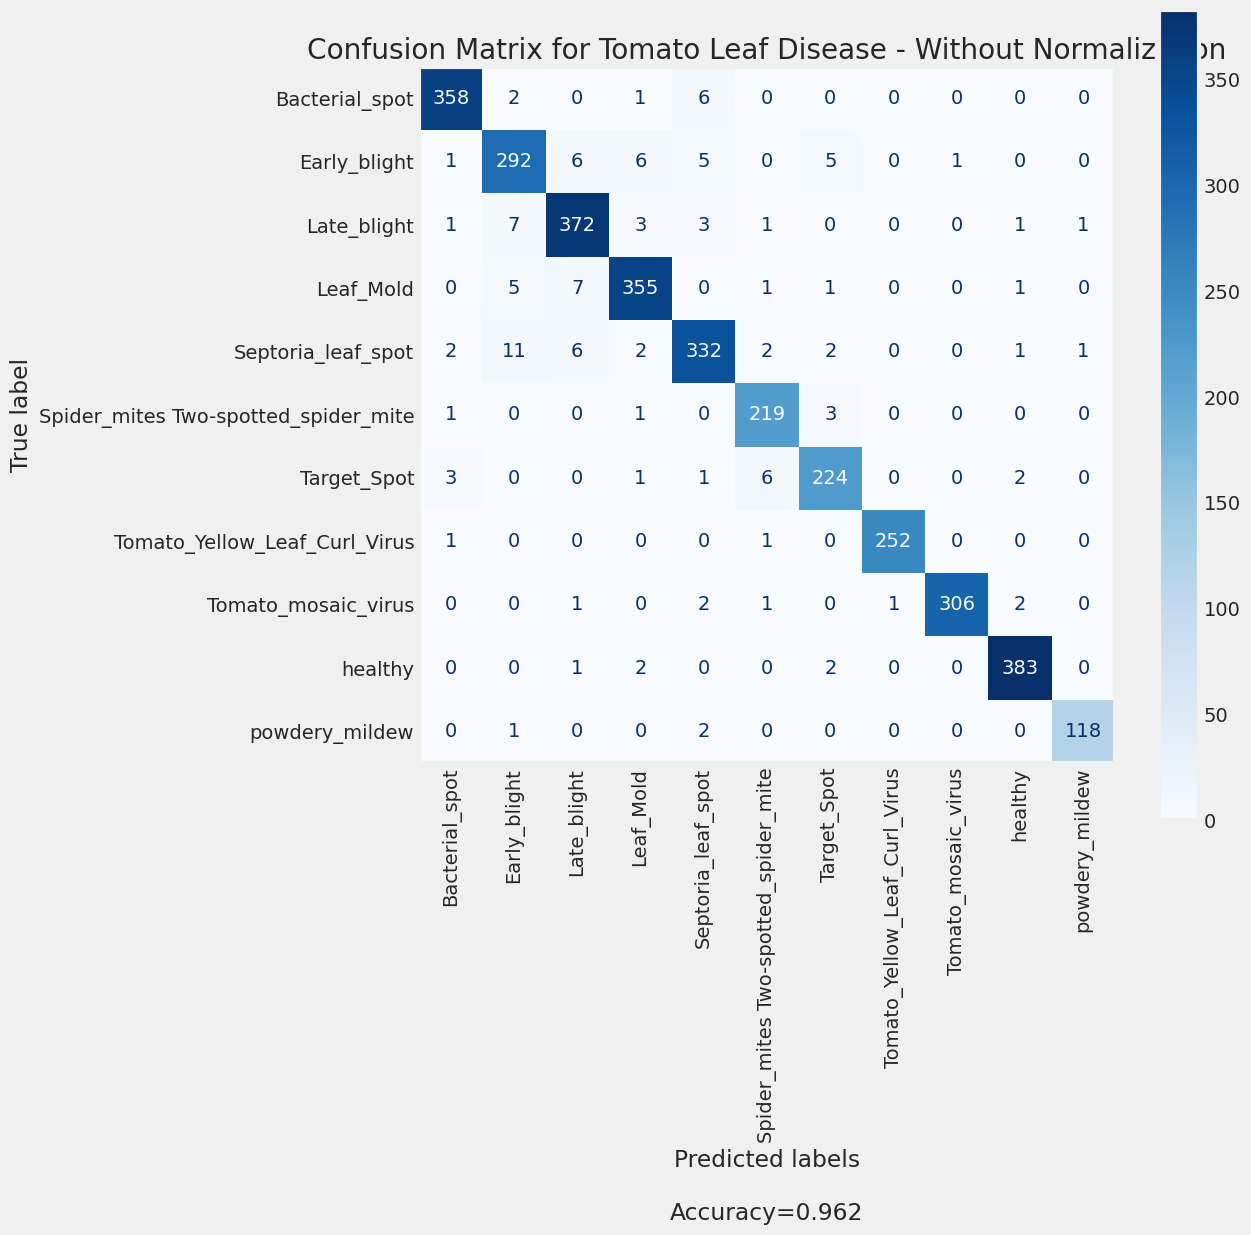

In [67]:
plt_confusion_mtrx(y_true, y_pred, target_names)